| ![nsdf](https://www.sci.utah.edu/~pascucci/public/NSDF-smaller.PNG)  | [National Science Data Fabric](https://nationalsciencedatafabric.org/) [Jupyter notebook](https://jupyter.org/) <br> created by [Duncan Greeley](https://www.linkedin.com/in/duncangreeley/), [John Allison](https://mse.engin.umich.edu/people/johnea), [Valerio Pascucci](http://cedmav.com/) and  [Giorgio Scorzelli](https://www.sci.utah.edu/people/scrgiorgio.html)  |  
|---|:---:|


# NSDF+Materials Commons example for Materials Science class  

In [1]:
import matplotlib.pyplot as plt, skimage, OpenVisus as ov, getversion as gv, packaging as pk, numpy as np
import requests
import shutil
import numpy as np
response = requests.get('http://www.sci.utah.edu/~pascucci/public/MgNd_nfHEDM_cropped_pointcloud.npy', stream=True)

with open('MgNd_nfHEDM_cache.npy', 'wb') as fin:
    shutil.copyfileobj(response.raw, fin)

Starting OpenVisus C:\Users\Vlaerio's PC\AppData\Roaming\Python\Python37\site-packages\OpenVisus\__init__.py 3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)] sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0) ...


In [2]:
inputfile = open('MgNd_nfHEDM_cache.npy', 'rb')
volume = np.load(inputfile)
print(volume.shape)

(92, 90, 90)


In [3]:
# inputfile = open('MgNd_nfHEDM_cache.npy', 'rb')
# #volume = np.load(inputfile)
# #volume = np.delete(volume,0,0)
# #volume = np.delete(volume,0,1)
# #volume = np.delete(volume,0,2)
# #np.save('MgNd_nfHEDM_cropped_pointcloud', volume)
# #inputfile = open('MgNd_nfHEDM_cropped_pointcloud.npy', 'rb')
# volume = np.load(inputfile)


# print(volume.shape)

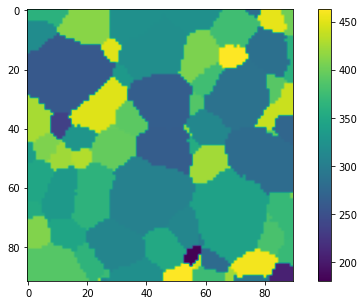

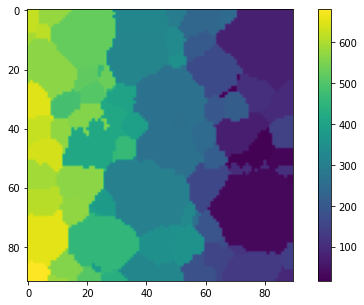

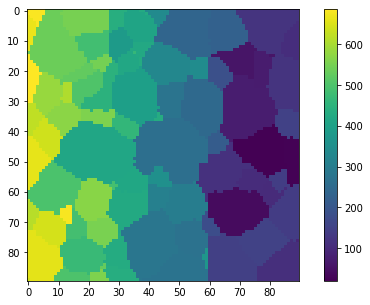

In [4]:
# Plot HEDM Slices, Colormapped by Grain ID

fig, plots = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,5)
#slice orthogonal to the x axis
slice = volume[:,:,40]
im = plots.imshow(slice) 
plt.colorbar(im)
plt.show()

fig, plots = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,5)
#slice orthogonal to the y axis
slice = volume[:,40,:]
im = plots.imshow(slice) 
plt.colorbar(im)
plt.show()

fig, plots = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,5)
#slice orthogonal to the z axis
slice = volume[45,:,:]
im = plots.imshow(slice) 
plt.colorbar(im)
plt.show()


In [5]:
# Calculate 3D Grain Size  
# -----------------------------------------------------------------------------
# Goal: Count the number of voxels contained in each 3D grain, calculate the 
# equivalent diameter for each grain assuming the volume is a perfect sphere
#
# HEDM Volume Mesh Information:
# 'volume' is an array of points representing the center of 10um^3 voxels of 
# size X=92, Y=90, Z=90 
# -----------------------------------------------------------------------------

# Find the total number of grains in the volume
vol_numgrains = np.amax(volume)+1
gs_voxels = np.zeros(vol_numgrains)

# Calculate the number of voxels in each grain
for i in range(len(gs_voxels)):
    gs_voxels[i] = np.count_nonzero(volume == i)

grain_vol_3D = gs_voxels*10**3
grain_size_3D = ((grain_vol_3D/((4/3)*np.pi))**(1/3))*2
mean_3D_grain_size = np.mean(grain_size_3D)


In [6]:
#Calculate 2D Grain Size with the Intercept Method
# -----------------------------------------------------------------------------
# Goal: Create a 2D planar slice of the microstructure, loop through all lines
# parallel to each 2D axis, and count the number of times the lines intercept
# a grain boundary and the corresponding intercept length in voxels.
# -----------------------------------------------------------------------------

# Build three lits of len(xslice), len(yslice), len(zslice) for int lengths
slice_int_lengths = list(range(3))
for i in range(3):
    slice_int_lengths[i] = list(range(np.shape(volume)[i]))

for axis in range (3): 
    # Calculate with slices along X/Y/Z, global axis 0/1/2
 
    for layerslice_idx in range(np.shape(volume)[axis]): 
        # Loop through all slices perpendicular to slice axis

        int_length_count = np.array([], dtype=int)
        gid_hash = 0

        if axis == 0:
            volslice = volume[layerslice_idx,:,:]
        elif axis == 1:
            volslice = volume[:,layerslice_idx,:]
        elif axis == 2:
            volslice = volume[:,:,layerslice_idx]
        
        # At each value of axis 1, find int lengths on line parallel to axis 2
        # I.e. slice Z plane, at each X find int length on line parallel to Y
        for i in range(np.shape(volslice)[0]): # Loop through slice axis 1
            for j in range(np.shape(volslice)[1]): # Loop through slice axis 2
                
                if j == 0:
                    # Initiate a new GrainID voxel count at the start of each line
                    gid_hash = volslice[i,j]              
                    int_length_hash = 1 
                    continue
                
                if gid_hash == volslice[i,j]: 
                    # If the GID of voxel j is the same as j-1, add to the length hash
                    int_length_hash += 1
                    
                else: 
                    # If the GID of voxel j changes from j-1, you passed a 
                    # grain boundary. Stop the intercept length hash and start 
                    # a new one    
                    
                    # Build a numpy array with all intercept lengths for a 
                    # given 2D slice
                    int_length_count = np.append(int_length_count,int_length_hash) 
                    int_length_hash = 1
                    gid_hash = volslice [i,j]
        
        # Invert the slice and check int lengths on line para|llel to axis 1
        # I.e. slice Z plane, at each Y find int length on line parallel to X
        volslice = np.transpose(volslice)
        for i in range(np.shape(volslice)[0]): # Loop through slice axis 1
            for j in range(np.shape(volslice)[1]): # Loop through slice axis 2
                
                if j == 0:
                    # Initiate a new GrainID voxel count at the start of each line
                    gid_hash = volslice[i,j]              
                    int_length_hash = 1 
                    continue
                
                if gid_hash == volslice[i,j]: 
                    # If the GID of voxel j is the same as j-1, add to the length hash
                    int_length_hash += 1
                    
                else: 
                    # If the GID of voxel j changes from j-1, you passed a 
                    # grain boundary. Stop the intercept length hash and start 
                    # a new one    
                    
                    # Build a numpy array with all intercept lengths for a 
                    # given 2D slice
                    int_length_count = np.append(int_length_count,int_length_hash) 
                    int_length_hash = 1
                    gid_hash = volslice [i,j]
                    
        slice_int_lengths[axis][layerslice_idx] = int_length_count 

In [7]:
# Calculate 2D Grain Size with the Area Method
# -----------------------------------------------------------------------------
# Goal: Create a 2D planar slice of the microstructure, count the number of 
# voxels contained in each grain on the slice, calculate the equivalent
# diameter for each grain assuming the area is a perfect circle
# -----------------------------------------------------------------------------

slice_area_lengths = list(range(3))
for i in range(3):
    slice_area_lengths[i] = list(range(np.shape(volume)[i]))

for axis in range (3): 
    # Calculate with slices along X/Y/Z, global axis 0/1/2
 
    for layerslice_idx in range(np.shape(volume)[axis]): 
        # Loop through all slices perpendicular to slice axis
        
        if axis == 0:
            volslice = volume[layerslice_idx,:,:]
        elif axis == 1:
            volslice = volume[:,layerslice_idx,:]
        elif axis == 2:
            volslice = volume[:,:,layerslice_idx]        
        
        count_voxels = np.zeros(len(np.unique(volslice)))
        for i in range(len(count_voxels)):
            # Count the number of voxels in each grain present in the 2D slice
            count_voxels[i] = np.count_nonzero(volslice == np.unique(volslice)[i])
            
        slice_area_lengths[axis][layerslice_idx] = count_voxels

In [8]:
# Calculate 3D Grain Size , Exclude Edge Grains 
# -----------------------------------------------------------------------------
# Goal: Count the number of voxels contained in each 3D grain, calculate the 
# equivalent diameter for each grain assuming the volume is a perfect sphere
#
# HEDM Volume Mesh Information:
# 'volume' is an array of points representing the center of 10um^3 voxels of 
# size X=92, Y=90, Z=90 
# -----------------------------------------------------------------------------

# Find the total number of grains in the volume
vol_numgrains = np.amax(volume)
gs_voxels = np.zeros(vol_numgrains)
    
# Find all edge grain IDs 
edge_id = np.array([])
edge_id = np.append(edge_id,np.unique(volume[0,:,:]))
edge_id = np.append(edge_id,np.unique(volume[-1,:,:]))
edge_id = np.append(edge_id,np.unique(volume[:,0,:]))
edge_id = np.append(edge_id,np.unique(volume[:,-1,:]))
edge_id = np.append(edge_id,np.unique(volume[:,:,0]))
edge_id = np.append(edge_id,np.unique(volume[:,:,-1]))
edge_id = np.unique(edge_id) 

# Calculate the number of voxels in each grain
for i in range(len(gs_voxels)):
    if np.isin(i,edge_id) == True:
        # If the grain ID is an edge grain then skip 
        continue
    gs_voxels[i] = np.count_nonzero(volume == i)
gs_voxels = gs_voxels[gs_voxels != 0]

grain_vol_3D_ignore_edge = gs_voxels*10**3
grain_size_3D_ignore_edge = ((grain_vol_3D_ignore_edge/((4/3)*np.pi))**(1/3))*2
mean_3D_grain_size_ignore_edge = np.mean(grain_size_3D_ignore_edge)


In [9]:
# Calculate 2D Grain Size with the Intercept Method, Exclude Edge Grains
# -----------------------------------------------------------------------------
# Goal: Create a 2D planar slice of the microstructure, loop through all lines
# parallel to each 2D axis, and count the number of times the lines intercept
# a grain boundary and the corresponding intercept length in voxels.
#
# Exlude all grains bordering the Start/End edge of the intercept line from the
# analysis. The intercept length in these edge grains would be under-counted as
# part of the grain volume is cut off by the sample edge. Example:
#
#   :           |           |           |           |           :      Y 
#   :  Grain 1  |  Grain 2  |  Grain 3  |  Grain 4  |  Grain 5  :      ^
#   :           |           |           |           |           :      |
#  Edge        GB1         GB2         GB3         GB4         Edge    ----> X  
#
# When tracking intercept length along line parallel to X, ignore grain 1 and 
# grain 5 that border the edge of the sample.
# -----------------------------------------------------------------------------

# Build three lits of len(xslice), len(yslice), len(zslice) for int lengths
slice_int_lengths_ignore_edge = list(range(3))
for i in range(3):
    slice_int_lengths_ignore_edge[i] = list(range(np.shape(volume)[i]))

for axis in range (3): 
    # Calculate with slices along X/Y/Z, global axis 0/1/2
 
    for layerslice_idx in range(np.shape(volume)[axis]): 
        # Loop through all slices perpendicular to slice axis

        int_length_count = np.array([], dtype=int)
        gid_hash = 0

        if axis == 0:
            volslice = volume[layerslice_idx,:,:]
        elif axis == 1:
            volslice = volume[:,layerslice_idx,:]
        elif axis == 2:
            volslice = volume[:,:,layerslice_idx]
        
        # At each value of axis 1, find int lengths on line parallel to axis 2
        # I.e. slice Z plane, at each X find int length on line parallel to Y
        for i in range(np.shape(volslice)[0]): # Loop through slice axis 1
            edge_hash = 0
            for j in range(np.shape(volslice)[1]): # Loop through slice axis 2
                
                if j == np.shape(volslice)[1]-1:
                    # If you reach the final voxel at the edge of the sample,
                    # skip appending intercept length and move to next line
                    int_length_hash = 1

                if j == 0:
                    # Initiate a new GrainID voxel count at the start of each line
                    gid_hash = volslice[i,j]              
                    int_length_hash = 1 
                    edge_hash = 1
                    continue
                
                if gid_hash == volslice[i,j]: 
                    # If the GID of voxel j is the same as j-1, add to the length hash
                    int_length_hash += 1
                    
                else: 
                    # If the GID of voxel j changes from j-1, you passed a 
                    # grain boundary. Stop the intercept length hash and start 
                    # a new one    

                    # Skip appending intercept length if edge grain                   
                    if edge_hash == 1:
                        int_length_hash = 1
                        gid_hash = volslice [i,j]
                        edge_hash = 0
                        continue        
                    
                    # Build a numpy array with all intercept lengths for a 
                    # given 2D slice
                    int_length_count = np.append(int_length_count,int_length_hash) 
                    int_length_hash = 1
                    gid_hash = volslice [i,j]
        
        # Invert the slice and check int lengths on line para|llel to axis 1
        # I.e. slice Z plane, at each Y find int length on line parallel to X
        volslice = np.transpose(volslice)
        for i in range(np.shape(volslice)[0]): # Loop through slice axis 1
            edge_hash = 0
            for j in range(np.shape(volslice)[1]): # Loop through slice axis 2
                
                if j == np.shape(volslice)[1]-1:
                    # If you reach the final voxel at the edge of the sample,
                    # skip appending intercept length and move to next line
                    int_length_hash = 1            
            
                if j == 0:
                    # Initiate a new GrainID voxel count at the start of each line
                    gid_hash = volslice[i,j]              
                    int_length_hash = 1 
                    continue
                
                if gid_hash == volslice[i,j]: 
                    # If the GID of voxel j is the same as j-1, add to the length hash
                    int_length_hash += 1
                    
                else: 
                    # If the GID of voxel j changes from j-1, you passed a 
                    # grain boundary. Stop the intercept length hash and start 
                    # a new one    
                    
                    # Skip appending intercept length if edge grain
                    if edge_hash == 1:
                        int_length_hash = 1
                        gid_hash = volslice [i,j]
                        edge_hash = 0
                        continue     
                    
                    # Build a numpy array with all intercept lengths for a 
                    # given 2D slice
                    int_length_count = np.append(int_length_count,int_length_hash) 
                    int_length_hash = 1
                    gid_hash = volslice [i,j]
                    
        slice_int_lengths_ignore_edge[axis][layerslice_idx] = int_length_count 

In [10]:
# Calculate 2D Grain Size with the Area Method, Exclude Edge Grains
# -----------------------------------------------------------------------------
# Goal: Create a 2D planar slice of the microstructure, count the number of 
# voxels contained in each grain on the slice, calculate the equivalent
# diameter for each grain assuming the area is a perfect circle

# Exlude all grains bordering the Start/End edge of the intercept line from the
# analysis. The intercept length in these edge grains would be under-counted as
# part of the grain volume is cut off by the sample edge. Example:
#
#                         Sample Edge
#               -------------------------------
#               | Grain 1 | Grain 2 | Grain 3 |
#               |-----------------------------|
#   Sample Edge | Grain 4 | Grain 5 | Grain 6 | Sample Edge 
#               |-----------------------------|
#               | Grain 7 | Grain 8 | Grain 9 |
#               -------------------------------
#                         Sample Edge  
# 
# When tacking the area for all grains in the example slice, you would ignore
# the area of all grains except grain 5 as 1-4 and 6-9 border the sample edge
# -----------------------------------------------------------------------------

slice_area_lengths_ignore_edge = list(range(3))
for i in range(3):
    slice_area_lengths_ignore_edge[i] = list(range(np.shape(volume)[i]))

for axis in range (3): 
    # Calculate with slices along X/Y/Z, global axis 0/1/2
 
    for layerslice_idx in range(np.shape(volume)[axis]): 
        # Loop through all slices perpendicular to slice axis
        
        if axis == 0:
            volslice = volume[layerslice_idx,:,:]
        elif axis == 1:
            volslice = volume[:,layerslice_idx,:]
        elif axis == 2:
            volslice = volume[:,:,layerslice_idx]        
        
        # Find all edge grain IDs 
        edge_id = np.array([])
        for i in range(np.shape(volslice)[0]):
            edge_id = np.append(edge_id,volslice[i,0])
            edge_id = np.append(edge_id,volslice[i,-1])
        for i in range(np.shape(volslice)[1]):
            edge_id = np.append(edge_id,volslice[0,i])
            edge_id = np.append(edge_id,volslice[-1,i])            
        edge_gids = np.unique(edge_id)
        
        count_voxels = np.zeros(len(np.unique(volslice)))
        for i in range(len(count_voxels)):
            # Count the number of voxels in each grain present in the 2D slice
            
            if np.isin(np.unique(volslice)[i],edge_gids) == True:
                # If the grain ID is an edge grain then skip 
                continue
            
            count_voxels[i] = np.count_nonzero(volslice == np.unique(volslice)[i])
            
        count_voxels = count_voxels[count_voxels != 0]    
        slice_area_lengths_ignore_edge[axis][layerslice_idx] = count_voxels            


Text(0.5, 1.0, 'Z Slice = 30')

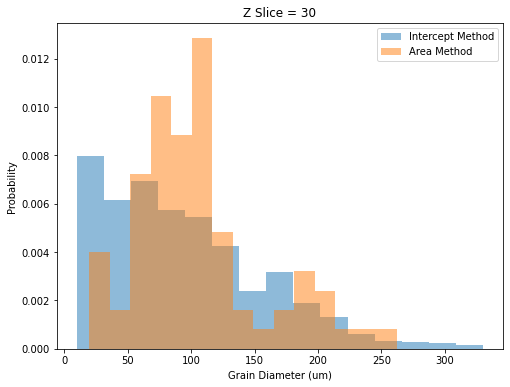

In [11]:
# Plot Histo Comparison of 2D Area and Intercept Grain Diameter Calc

# Compare z-slice #30 
plot_axis_label = ['X', 'Y', 'Z']
plot_axis = 2
plot_slice = 30

slice_int_hash = slice_int_lengths[plot_axis][plot_slice]
slice_area_hash = slice_area_lengths[plot_axis][plot_slice]

slice_int_plot = slice_int_hash*10 # Length in um
slice_area_plot = slice_area_hash*10**2 # Area in um^2
slice_area_plot = ((slice_area_plot/np.pi)**(1/2))*2 # 2D Diameter in um

plt.figure(figsize=(8,6))
plt.hist(slice_int_plot, bins=15, alpha=0.5, density=True, label='Intercept Method')
plt.hist(slice_area_plot, bins=15, alpha=0.5, density=True, label="Area Method")
plt.legend()
plt.xlabel('Grain Diameter (um)')
plt.ylabel('Probability')
plt.title('%s Slice = %d' % (plot_axis_label[plot_axis],plot_slice))

Text(0.5, 1.0, 'Z Slice = 30')

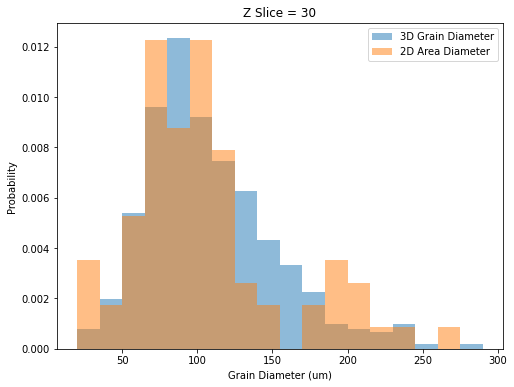

In [12]:
# Plot Histo Comparison of 2D Area Grain Diameter and 3D Grain Diameter

# Compare z-slice #30
plot_axis_label = ['X', 'Y', 'Z']
plot_axis = 2
plot_slice = 30

slice_area_hash = slice_area_lengths[plot_axis][plot_slice]

slice_area_plot = slice_area_hash*10**2 # Area in um^2
slice_area_plot = ((slice_area_plot/np.pi)**(1/2))*2 # 2D Diameter in um

plt.figure(figsize=(8,6))
bins_plot = np.linspace(20,290,int((290-20)/15)+1)
plt.hist(grain_size_3D, bins=bins_plot, alpha=0.5, density=True, label='3D Grain Diameter')
plt.hist(slice_area_plot, bins=bins_plot, alpha=0.5, density=True, label="2D Area Diameter")
plt.legend()
plt.xlabel('Grain Diameter (um)')
plt.ylabel('Probability')
plt.title('%s Slice = %d' % (plot_axis_label[plot_axis],plot_slice))

Text(0.5, 1.0, 'Z Slice = 15')

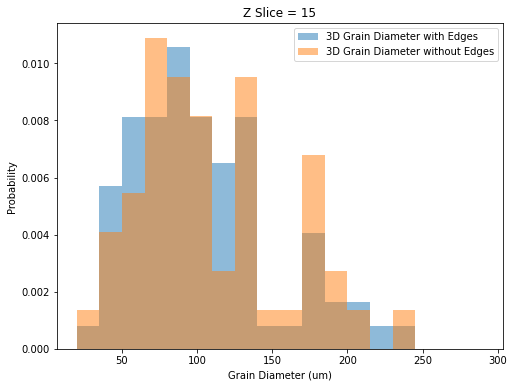

In [13]:
# Plot Histo Comparison of 2D Area Diameter With and Without Edge Grains

# Compare z-slice #30
plot_axis_label = ['X', 'Y', 'Z']
plot_axis = 2
plot_slice = 15

slice_area_hash = slice_area_lengths[plot_axis][plot_slice]
slice_area_plot = slice_area_hash*10**2 # Area in um^2
slice_area_plot = ((slice_area_plot/np.pi)**(1/2))*2 # 2D Diameter in um

slice_area_hash2 = slice_area_lengths_ignore_edge[plot_axis][plot_slice]
slice_area_plot2 = slice_area_hash2*10**2 # Area in um^2
slice_area_plot2 = ((slice_area_plot2/np.pi)**(1/2))*2 # 2D Diameter in um

plt.figure(figsize=(8,6))
bins_plot = np.linspace(20,290,int((290-20)/15)+1)
plt.hist(slice_area_plot, bins=bins_plot, alpha=0.5, density=True, label='3D Grain Diameter with Edges')
plt.hist(slice_area_plot2, bins=bins_plot, alpha=0.5, density=True, label="3D Grain Diameter without Edges")
plt.legend()
plt.xlabel('Grain Diameter (um)')
plt.ylabel('Probability')
plt.title('%s Slice = %d' % (plot_axis_label[plot_axis],plot_slice))

Text(0.5, 1.0, 'Z Slices')

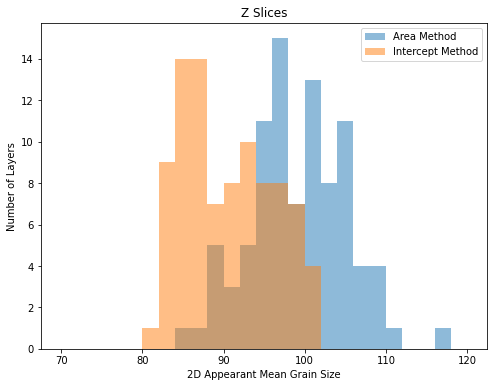

In [14]:
# Plot Distribution of Mean 2D Area Diameters for Each Z Slice

# Compare z-slices
plot_axis_label = ['X', 'Y', 'Z']
plot_axis = 2
slices_area = slice_area_lengths_ignore_edge[plot_axis]
slices_int= slice_int_lengths_ignore_edge[plot_axis]

slice_area_means_plot = np.zeros(len(slices_area))
slice_int_means_plot = np.zeros(len(slices_int))
slice_area_hash = list(range(len(slices_area)))
slice_int_hash = list(range(len(slices_int)))
for i in range(len(slice_area_means_plot)):
    slice_area_hash[i] = (((slices_area[i]*10**2)/np.pi)**(1/2))*2 # area d in um
    slice_int_hash[i] = slices_int[i]*10 # int length in um
    slice_area_means_plot[i] = np.mean(slice_area_hash[i])
    slice_int_means_plot[i] = np.mean(slice_int_hash[i])

    
plt.figure(figsize=(8,6))
bins_plot = np.linspace(70,120,int((120-70)/2)+1)
plt.hist(slice_area_means_plot, bins=bins_plot, alpha=0.5, density=False, label='Area Method')
plt.hist(slice_int_means_plot, bins=bins_plot, alpha=0.5, density=False, label="Intercept Method")
plt.legend()
plt.xlabel('2D Appearant Mean Grain Size')
plt.ylabel('Number of Layers')
plt.title('%s Slices' % (plot_axis_label[plot_axis]))